In [ ]:
# Togo Solar Data EDA
Exploratory data analysis for Togo's solar farm dataset to identify trends in solar radiation, temperature, and wind.

In [1]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv('../data/togo-dapaong_qc.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isna().sum())
print("\nPercentage of Missing Values:")
print((df.isna().sum() / len(df) * 100).round(2))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          

In [ ]:
## Data Cleaning
Handling missing values and outliers for key columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust).

In [2]:
# Handle missing values (impute with median for numeric columns)
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in key_columns:
    df[col] = df[col].fillna(df[col].median())

# Verify missing values after imputation
print("Missing Values After Imputation:")
print(df[key_columns].isna().sum())

# Handle outliers (remove rows with Z-scores > 3)
from scipy.stats import zscore
z_scores = df[key_columns].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")
df_clean = df[~outliers].copy()

# Save cleaned data
df_clean.to_csv('../data/togo_clean.csv', index=False)
print("Cleaned data saved to data/togo_clean.csv")

Missing Values After Imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Number of outliers detected: 9251
Cleaned data saved to data/togo_clean.csv


In [ ]:
## Time Series Analysis
Analyzing GHI, DNI, DHI, and Tamb over time to identify seasonal or diurnal patterns.

<Figure size 1200x800 with 0 Axes>

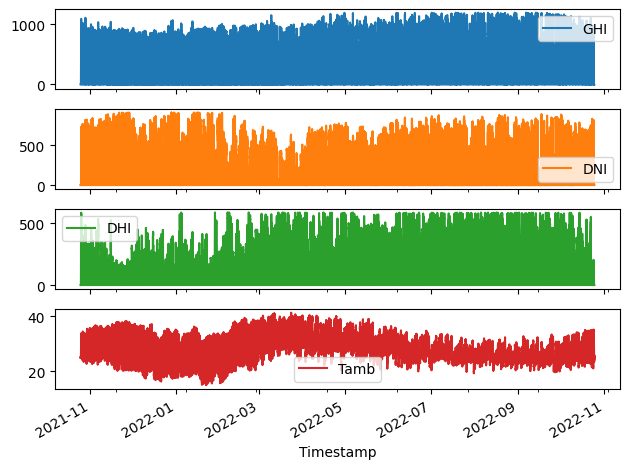

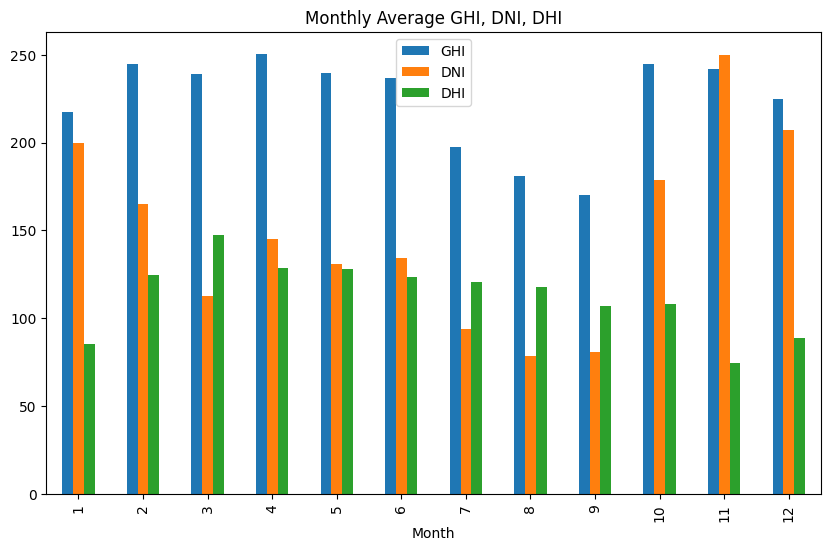

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs('figures', exist_ok=True)

# Convert Timestamp to datetime
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Plot time series
plt.figure(figsize=(12, 8))
df_clean.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(subplots=True)
plt.tight_layout()
plt.savefig('figures/togo_timeseries.png')
plt.show()

# Monthly averages
df_clean['Month'] = df_clean['Timestamp'].dt.month
monthly_avg = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI']].mean()
monthly_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Monthly Average GHI, DNI, DHI')
plt.savefig('figures/togo_monthly_avg.png')
plt.show()

In [ ]:
## Cleaning Impact
Comparing ModA and ModB before and after cleaning events.

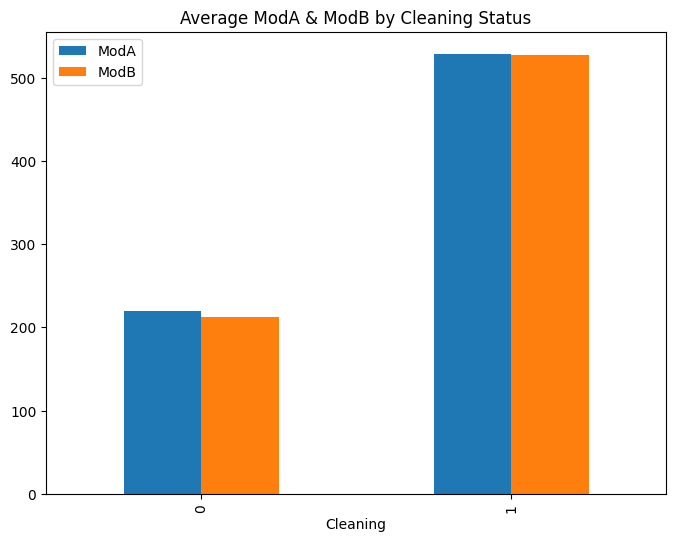

In [4]:
# Group by Cleaning status
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()
cleaning_impact.plot(kind='bar', figsize=(8, 6))
plt.title('Average ModA & ModB by Cleaning Status')
plt.savefig('figures/togo_cleaning_impact.png')
plt.show()

In [ ]:
## Correlation Analysis
Examining relationships between GHI, DNI, DHI, TModA, TModB, and other variables.

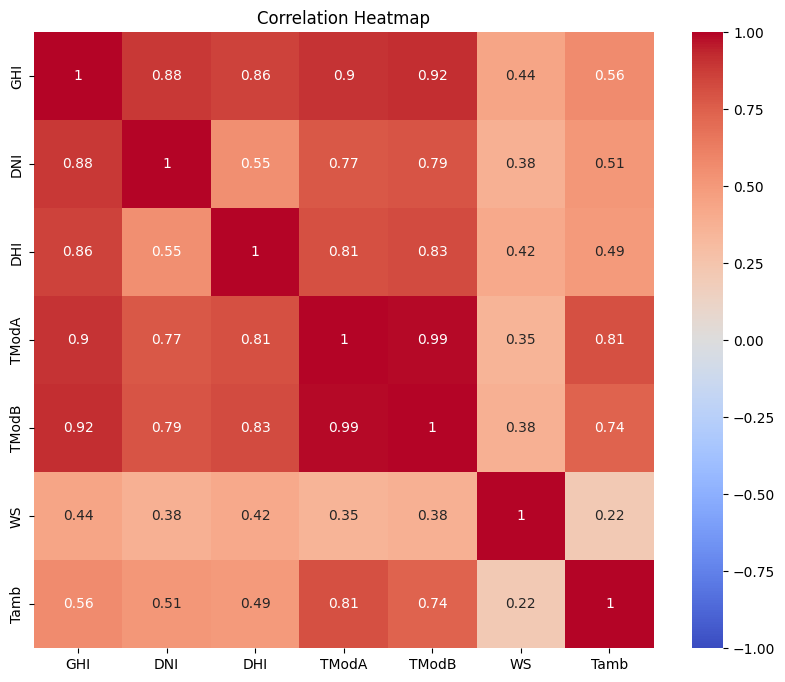

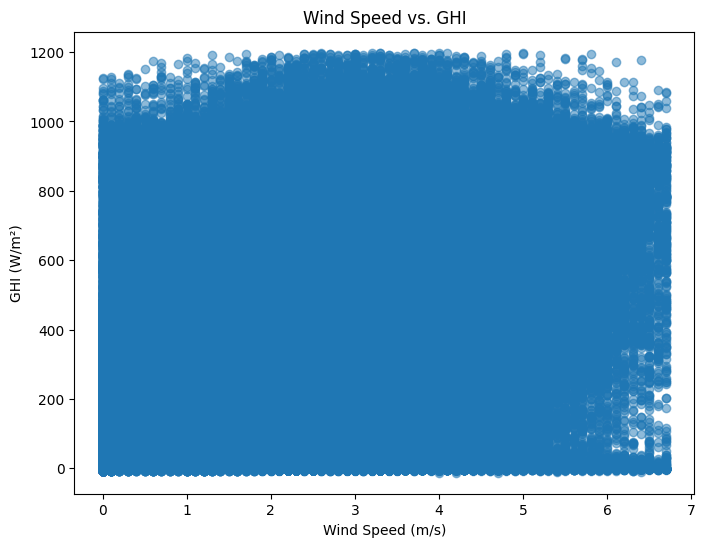

In [5]:
# Correlation heatmap
corr = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'WS', 'Tamb']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('figures/togo_correlation.png')
plt.show()

# Scatter plot: WS vs. GHI
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Speed vs. GHI')
plt.savefig('figures/togo_ws_ghi_scatter.png')
plt.show()

In [ ]:
## Wind and Distribution Analysis
Visualizing wind direction/speed and distributions of GHI and WS.

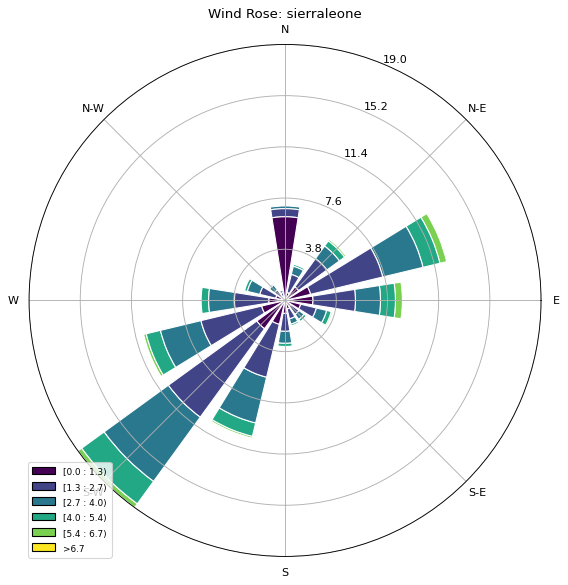

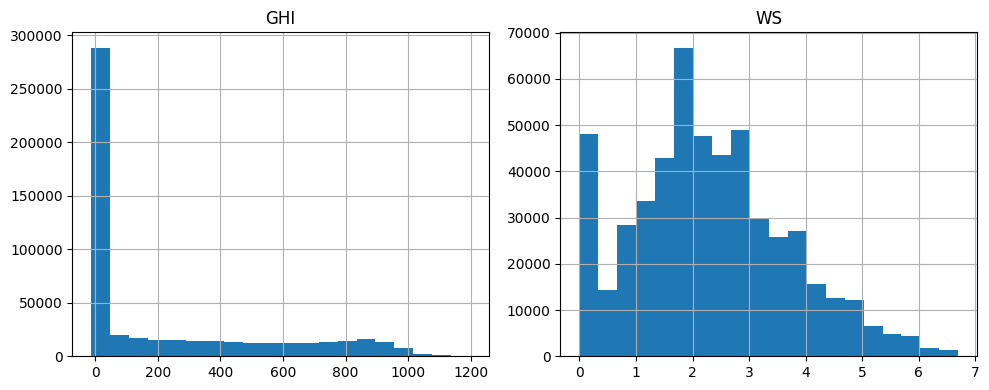

In [6]:
from windrose import WindroseAxes

# Wind rose
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose: sierraleone')
plt.savefig('figures/togo_windrose.png')
plt.show()

# Histograms
df_clean[['GHI', 'WS']].hist(bins=20, figsize=(10, 4))
plt.tight_layout()
plt.savefig('figures/togo_histograms.png')
plt.show()

In [ ]:
## Temperature and Humidity Analysis
Analyzing relationships between RH, Tamb, and GHI.

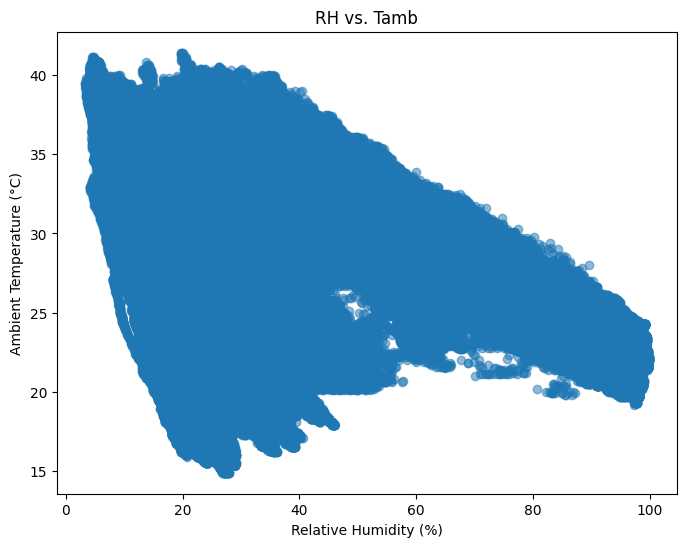

In [7]:
# Scatter: RH vs. Tamb
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5)
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('RH vs. Tamb')
plt.savefig('figures/togo_rh_tamb_scatter.png')
plt.show()

In [ ]:
## Bubble Chart
Visualizing GHI vs. Tamb with bubble size representing RH.

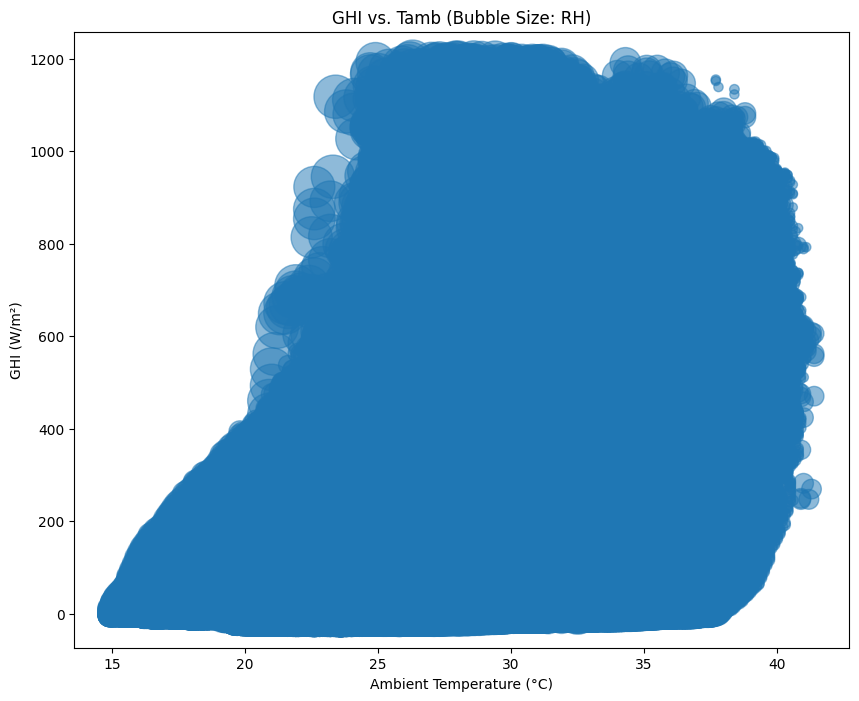

In [8]:
plt.figure(figsize=(10, 8))
plt.scatter(df_clean['Tamb'], df_clean['GHI'], s=df_clean['RH']*10, alpha=0.5)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs. Tamb (Bubble Size: RH)')
plt.savefig('figures/togo_bubble.png')
plt.show()